# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [157]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [158]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
book_cost

,Book Cost
Ticker,
BTCUSDT,69141.710000
TRXUSDT,0.164146
JASMYUSDT,0.035478
SOLUSDT,146.170000
OMUSDT,1.150000
ETHUSDT,3810.480000
BBUSDT,0.398000
BNBUSDT,674.930000
PEPEUSDT,0.000002


In [8]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [9]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [10]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))

realized_loss=63.514078
pnl.loc['Loss']=0
pnl.loc['Loss']['Book Cost']=realized_loss
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']

pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,582.7926,0.2808,-29.1654
TRXUSDT,79.6748,75.1381,0.0362,-4.5366
JASMYUSDT,453.8661,320.7180,0.1545,-133.1480
SOLUSDT,261.7091,281.8695,0.1358,20.1604
OMUSDT,535.6761,582.2101,0.2806,46.5340
ETHUSDT,264.2048,184.7204,0.0890,-79.4844
BBUSDT,46.3321,46.6929,0.0225,0.3609
BNBUSDT,1.1490,1.0428,0.0005,-0.1063
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Loss,63.5141,0.0000,0.0000,-63.5141


In [11]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [12]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [13]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [14]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [15]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [16]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [17]:
positions=positions.sort_index()

In [18]:
positions.index=pd.to_datetime(positions.index)

In [19]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [20]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [21]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [22]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [23]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [24]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [25]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [26]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [27]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

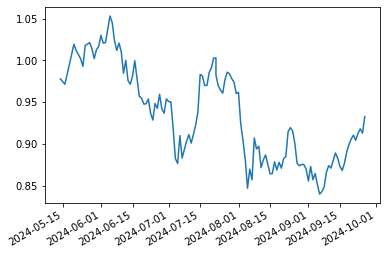

In [28]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [29]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [30]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [31]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [32]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9318
OMUSDT,0.0243
BNBUSDT,0.0210
TRXUSDT,0.0140
PEPEUSDT,0.0057
JASMYUSDT,0.0029
CKBUSDT,0.0003
FDUSDUSDT,0.0000
SUIUSDT,0.0000
BTCUSDT,0.0000


In [34]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.433846
BTCUSDT,0.400000
BNBUSDT,0.076411
PEPEUSDT,0.067260
JASMYUSDT,0.022483


In [35]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [36]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.742411
OMUSDT,0.257589


## Real Portfolio vs Optimal

In [37]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,582.792620,0.280839,0.000000,0.000000
OMUSDT,582.210060,0.280558,0.257589,0.022969
JASMYUSDT,320.718048,0.154549,0.000000,0.000000
SOLUSDT,281.869457,0.135829,0.000000,0.000000
ETHUSDT,184.720357,0.089014,0.000000,0.000000
TRXUSDT,75.138116,0.036208,0.742411,-0.706203
BBUSDT,46.692931,0.022501,0.000000,0.000000
BNBUSDT,1.042763,0.000503,0.000000,0.000000
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


In [38]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,582.792620,0.280839,0.400000,-0.119161
OMUSDT,582.210060,0.280558,0.433846,-0.153288
JASMYUSDT,320.718048,0.154549,0.022483,0.132066
SOLUSDT,281.869457,0.135829,0.000000,0.000000
ETHUSDT,184.720357,0.089014,0.000000,0.000000
TRXUSDT,75.138116,0.036208,0.000000,0.000000
BBUSDT,46.692931,0.022501,0.000000,0.000000
BNBUSDT,1.042763,0.000503,0.076411,-0.075909
PEPEUSDT,0.000003,0.000000,0.067260,-0.067260


# Risk Reward Analysis

In [39]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [40]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

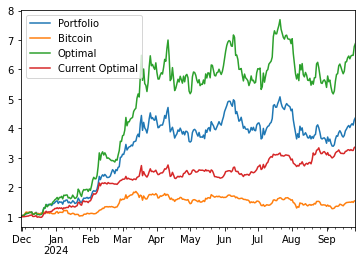

In [41]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [42]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

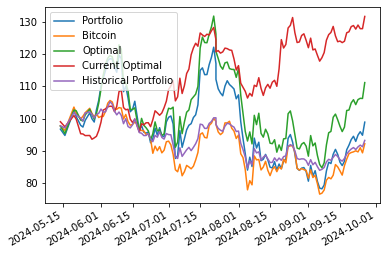

In [43]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [44]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-17,86.861447,85.509833,97.417282,123.958519,87.744993
2024-09-18,90.419570,87.535703,102.555265,126.578127,89.097407
2024-09-19,91.844879,89.203528,102.694231,126.886771,89.983209
2024-09-20,93.570719,89.561420,104.902328,128.486603,90.649751
2024-09-21,94.591121,89.770777,105.891338,128.812180,91.097867
2024-09-22,92.999258,90.095833,104.364688,127.704010,90.480102
2024-09-23,94.933946,89.756842,105.920068,128.969978,91.298984
2024-09-24,95.996577,91.054949,106.319631,127.840329,91.853987
2024-09-25,94.900409,89.467434,106.267801,127.842369,91.339446
2024-09-26,98.952226,92.287070,111.176014,131.624284,93.306318


## Volatilities

In [45]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.690072
dtype: float64

In [46]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.551137
dtype: float64

In [47]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.598132
Bitcoin            0.442191
Optimal            0.691185
Current Optimal    0.421403
dtype: float64

In [48]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20525495823007406

## Risk Contribution

In [49]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.101600,0.076411,0.017077,0.025273,0.002958,0.022315
BTCUSDT,0.221603,0.400000,0.059632,0.170124,0.065486,0.104638
JASMYUSDT,0.036239,0.022483,0.005633,0.013888,0.001251,0.012637
OMUSDT,8.877033,0.433846,0.893224,0.729321,0.624600,0.104721
PEPEUSDT,0.187430,0.067260,0.024433,0.061393,0.015786,0.045607


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.117378,0.257589,0.295844,0.488389,0.422548,0.065841
TRXUSDT,0.150071,0.742411,0.704156,0.511611,0.445769,0.065841


In [51]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.000141,0.28,0.251651,0.180221,0.044505,0.135716
OMUSDT,0.127590,0.28,0.366507,0.352911,0.189693,0.163218
JASMYUSDT,0.008729,0.15,0.142730,0.215591,0.071374,0.144217
SOLUSDT,-0.007649,0.14,0.119011,0.141178,0.029135,0.112043
ETHUSDT,-0.014966,0.09,0.067471,0.070129,0.008002,0.062127
TRXUSDT,0.008086,0.04,0.043239,0.006355,0.000492,0.005863
BBUSDT,-0.009556,0.02,0.009392,0.033615,0.002688,0.030927


# Value At Risk

## Historical

In [52]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.057791341933346965, -0.08103700004999974)

In [53]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05124550926495536, -0.0709849850141754)

In [54]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [55]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.015666
OMUSDT      -0.007549
JASMYUSDT   -0.007218
SOLUSDT     -0.009521
ETHUSDT     -0.007823
TRXUSDT     -0.000926
BBUSDT      -0.002220
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050923
Name: 2024-08-27 00:00:00, dtype: float64

In [56]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.012905
OMUSDT      -0.021927
JASMYUSDT   -0.014627
SOLUSDT     -0.010846
ETHUSDT     -0.005388
TRXUSDT     -0.000788
BBUSDT      -0.001997
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068477
dtype: float64

## Parametric

In [57]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.071617802019669, -0.09179422096361373)

In [58]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05710665356335988, -0.07319494075296984)

## Multivariate

In [59]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06512089323829284, -0.08422098503073394)

In [60]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05481925482554306, -0.06990833269740448)

In [61]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.010868
OMUSDT      -0.019018
JASMYUSDT   -0.011430
SOLUSDT     -0.008061
ETHUSDT     -0.004186
TRXUSDT     -0.000256
BBUSDT      -0.001520
Portfolio   -0.055340
dtype: float64

## Copulas

### Gaussian Copula

In [62]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.062296157845506836, -0.07983070226752245)

In [63]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055352860409285, -0.06965504201600416)

In [64]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010587
OMUSDT      -0.018219
JASMYUSDT   -0.011352
SOLUSDT     -0.008654
ETHUSDT     -0.004347
TRXUSDT     -0.000272
BBUSDT      -0.002013
Portfolio   -0.055444
dtype: float64

### Student Copula

In [65]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06350274152447712, -0.08171178504434749)

In [66]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05560811518907769, -0.07078270141286061)

In [67]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.009969
OMUSDT      -0.018931
JASMYUSDT   -0.013185
SOLUSDT     -0.007922
ETHUSDT     -0.004194
TRXUSDT     -0.000257
BBUSDT      -0.002084
Portfolio   -0.056541
dtype: float64

### Gumbel Copula

In [68]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.128578175931142, -0.18335282633062105)

In [69]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0703310668905901, -0.09566267366166963)

In [70]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.008933
OMUSDT      -0.040879
JASMYUSDT   -0.012262
SOLUSDT     -0.006416
ETHUSDT     -0.000895
TRXUSDT      0.000021
BBUSDT      -0.000255
Portfolio   -0.069619
dtype: float64

### Monte Carlo

In [71]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [72]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07286717356929374, -0.09297459382604471)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.057927906575246026, -0.07240057659908712)

In [74]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.010365
OMUSDT      -0.020121
JASMYUSDT   -0.013410
SOLUSDT     -0.008123
ETHUSDT     -0.004045
TRXUSDT     -0.000282
BBUSDT      -0.001796
Portfolio   -0.058143
dtype: float64

## VaR Violation

In [75]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.057677,-0.101072,-0.086463,-0.024400
2024-01-15,-0.057677,-0.101079,-0.087755,0.018244
2024-01-16,-0.057677,-0.101556,-0.083383,0.055164
2024-01-17,-0.057677,-0.103801,-0.085541,-0.033762
2024-01-18,-0.057677,-0.105787,-0.089645,-0.032923
...,...,...,...,...
2024-09-23,-0.043813,-0.073156,-0.071190,0.014903
2024-09-24,-0.043813,-0.071825,-0.069659,0.003772
2024-09-25,-0.043776,-0.069127,-0.063644,-0.000487
2024-09-26,-0.039440,-0.067935,-0.061698,0.046187


In [76]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031638,-0.085290,-0.078772,-0.017777
2024-05-29,-0.028927,-0.082375,-0.072819,-0.010068
2024-05-30,-0.028927,-0.071479,-0.066056,0.038500
2024-05-31,-0.028927,-0.070601,-0.061814,0.028058
2024-06-01,-0.028927,-0.071935,-0.062526,0.041604
...,...,...,...,...
2024-09-23,-0.025571,-0.054742,-0.043042,0.020803
2024-09-24,-0.025571,-0.047346,-0.037479,0.011193
2024-09-25,-0.025571,-0.046479,-0.039391,-0.011419
2024-09-26,-0.025571,-0.050672,-0.041663,0.042695


<AxesSubplot:>

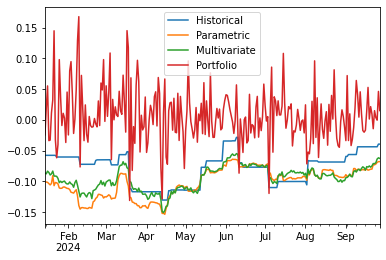

In [77]:
var_data.plot()

<AxesSubplot:>

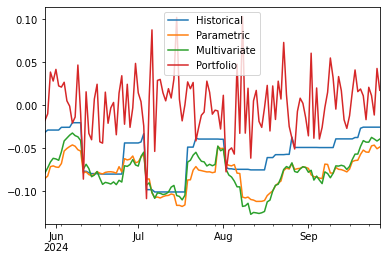

In [78]:
current_var_data.plot()

In [79]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.01938,0.011628,0.011628
Kupiec Stat,6.574044,11.44291,11.44291
P-value,0.010348,0.000718,0.000718


In [80]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.056911,0.02439,0.02439
Kupiec Stat,0.118611,2.077125,2.077125
P-value,0.730546,0.149522,0.149522


## Principal Component Analysis

### Historical PCA

In [81]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78800189, 0.06738845, 0.05424743, 0.0461228 , 0.04423943])

In [82]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014103
ADAUSDT     0.014498
ALGOUSDT    0.015980
APTUSDT     0.015327
ARBUSDT     0.015553
              ...   
WLDUSDT     0.021558
XECUSDT     0.015554
XLMUSDT     0.009651
XRPUSDT     0.009236
XTZUSDT     0.014553
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

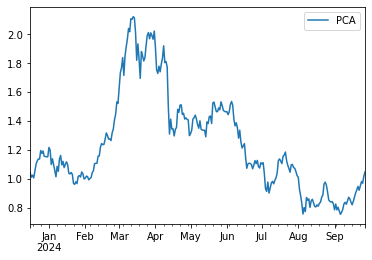

In [83]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

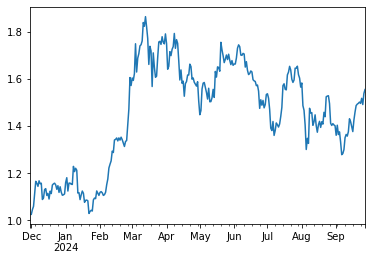

In [84]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [85]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
XTZUSDT      0.335566
ADAUSDT      0.338535
ALGOUSDT     0.347914
WBETHUSDT    0.353880
               ...   
PEPEUSDT     0.997270
FLOKIUSDT    1.009748
WLDUSDT      1.045571
CKBUSDT      1.149596
OMUSDT       1.313681
Length: 65, dtype: float64

<AxesSubplot:>

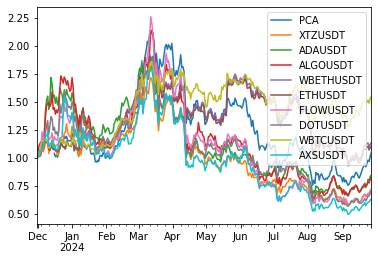

In [86]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

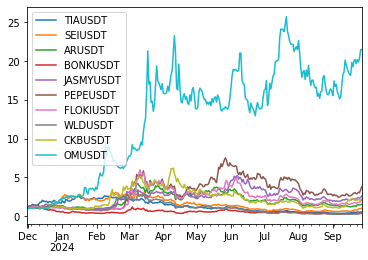

In [87]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [88]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66870674, 0.14034435, 0.0876411 , 0.07086032, 0.03244748])

In [89]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063977
OMUSDT       0.099826
JASMYUSDT    0.154440
SOLUSDT      0.103765
ETHUSDT      0.086079
TRXUSDT      0.015266
BBUSDT       0.244060
BNBUSDT      0.068029
PEPEUSDT     0.164558
Name: PC1, dtype: float64

<AxesSubplot:>

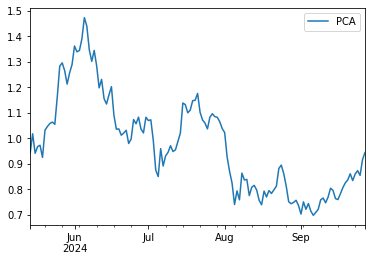

In [90]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

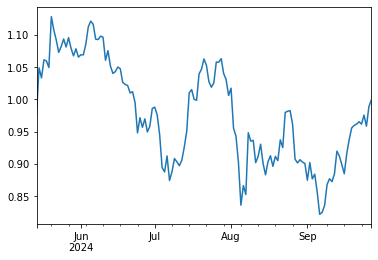

In [91]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [92]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.333013
SOLUSDT      0.344137
BTCUSDT      0.366221
BNBUSDT      0.366530
JASMYUSDT    0.428145
PEPEUSDT     0.465225
OMUSDT       0.538071
TRXUSDT      0.543225
BBUSDT       0.624908
dtype: float64

<AxesSubplot:>

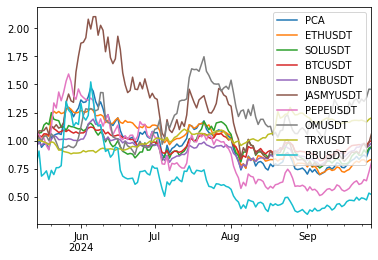

In [93]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [94]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.945038
BBUSDT       1.678156
JASMYUSDT    1.284490
SOLUSDT      1.166691
BTCUSDT      1.000000
OMUSDT       0.986771
ETHUSDT      0.954285
BNBUSDT      0.671799
TRXUSDT      0.280661
Name: BTCUSDT, dtype: float64

In [95]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.847125
BBUSDT       1.708091
JASMYUSDT    1.367566
SOLUSDT      1.038468
BTCUSDT      1.000000
ETHUSDT      0.855028
BNBUSDT      0.703911
OMUSDT       0.259637
TRXUSDT      0.053339
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [96]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.622138,0.000000,0.0,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.000000,0.625881,0.150844,0.000000,0.0,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.000000,0.182521,0.000000,0.000000,0.0,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.414537,0.133222,0.000000,0.111977,0.0,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.0,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.000000,0.435173,0.000000,0.000000,0.0,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.287486,0.000000,0.000000,0.0,0.000000,0.712514,0.000000,0.000000


In [97]:
(rolling_optimization>0.25).sum()

BTCUSDT      1
OMUSDT       3
JASMYUSDT    2
SOLUSDT      0
ETHUSDT      0
TRXUSDT      5
BBUSDT       1
BNBUSDT      0
PEPEUSDT     1
dtype: int64